## Access Animal Tracking Acoustic Tagging data in Parquet

A jupyter notebook to show how to access and plot Animal Tracking Acoustic Tagging data available as a [Parquet](https://parquet.apache.org) dataset on S3

In [1]:
dataset_name = "aatams_acoustic_tagging"

In [2]:
from parquet_queries import create_time_filter, create_bbox_filter, query_unique_value, plot_spatial_extent, get_spatial_extent, get_temporal_extent, get_schema_metadata
import pyarrow.parquet as pq
import pyarrow.dataset as pds
import pyarrow as pa
import os
import pandas as pd
import pyarrow.compute as pc

## Location of the parquet dataset

In [3]:
BUCKET_OPTIMISED_DEFAULT="imos-data-lab-optimised"
dname = f"s3://{BUCKET_OPTIMISED_DEFAULT}/parquet/loz_test/{dataset_name}.parquet/"
parquet_ds = pq.ParquetDataset(dname,partitioning='hive')

# Understanding the Dataset

## Get partition keys
Partitioning in Parquet involves organising data files based on the values of one or more columns, known as partition keys. When data is written to Parquet files with partitioning enabled, the files are physically stored in a directory structure that reflects the partition keys. This directory structure makes it easier to retrieve and process specific subsets of data based on the partition keys.

In [4]:
dataset = pds.dataset(dname, format="parquet", partitioning="hive")

partition_keys = dataset.partitioning.schema
print(partition_keys)

transmitter_id: string
timestamp: int32
polygon: string


## List unique partition values

In [5]:
%%time
unique_partition_value = query_unique_value(parquet_ds, 'transmitter_id')
print(list(unique_partition_value)[0:2])  # showing a subset only

['A69-1105-12', 'A69-1105-110']
CPU times: user 14.4 ms, sys: 768 µs, total: 15.2 ms
Wall time: 26.4 ms


## Visualise Spatial Extent of the dataset
In this section, we're plotting the polygons where data exists. This helps then with creating a bounding box where there is data

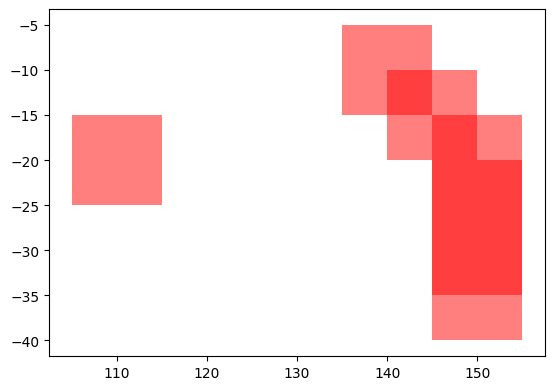

In [6]:
plot_spatial_extent(parquet_ds)

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [7]:
get_temporal_extent(parquet_ds)

(datetime.datetime(2008, 1, 1, 11, 0), datetime.datetime(2016, 8, 1, 10, 0))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [8]:
# parquet_meta = pa.parquet.read_schema(os.path.join(dname + '_common_metadata'))  # parquet metadata
metadata = get_schema_metadata(dname)  # schema metadata
metadata

{'detection_timestamp': {'type': 'timestamp[ns]',
  'standard_name': 'time',
  'long_name': '',
  'units': 's',
  'comments': ''},
 'transmitter_id': {'type': 'string',
  'standard_name': '',
  'long_name': '',
  'units': '',
  'comments': ''},
 'installation_name': {'type': 'string',
  'standard_name': '',
  'long_name': '',
  'units': '',
  'comments': ''},
 'station_name': {'type': 'string',
  'standard_name': '',
  'long_name': '',
  'units': '',
  'comments': ''},
 'receiver_name': {'type': 'string',
  'standard_name': '',
  'long_name': '',
  'units': '',
  'comments': ''},
 'latitude': {'type': 'double',
  'standard_name': '',
  'long_name': '',
  'units': '',
  'comments': ''},
 'longitude': {'type': 'double',
  'standard_name': '',
  'long_name': '',
  'units': '',
  'comments': ''},
 'sensor_value': {'type': 'double',
  'standard_name': '',
  'long_name': '',
  'units': '',
  'comments': ''},
 'sensor_unit': {'type': 'string',
  'standard_name': '',
  'long_name': '',
  'unit

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [9]:
filter_time = create_time_filter(parquet_ds, date_start='2009-06-01', date_end='2010-01-01', time_varname='detection_timestamp')
filter_geo = create_bbox_filter(parquet_ds, lat_min=-20, lat_max=-10, lon_min=140, lon_max=143, lat_varname='latitude', lon_varname='longitude')

filter = filter_geo & filter_time

In [10]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10912 entries, 0 to 10911
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   detection_timestamp       10912 non-null  datetime64[ns]
 1   installation_name         10912 non-null  object        
 2   station_name              10912 non-null  object        
 3   receiver_name             10912 non-null  object        
 4   latitude                  10912 non-null  float64       
 5   longitude                 10912 non-null  float64       
 6   sensor_value              10912 non-null  float64       
 7   sensor_unit               10912 non-null  object        
 8   FDA_QC                    10912 non-null  float32       
 9   Velocity_QC               10912 non-null  float32       
 10  Distance_QC               10912 non-null  float32       
 11  DetectionDistribution_QC  10912 non-null  float32       
 12  DistanceRelease_QC

<Axes: xlabel='longitude', ylabel='latitude'>

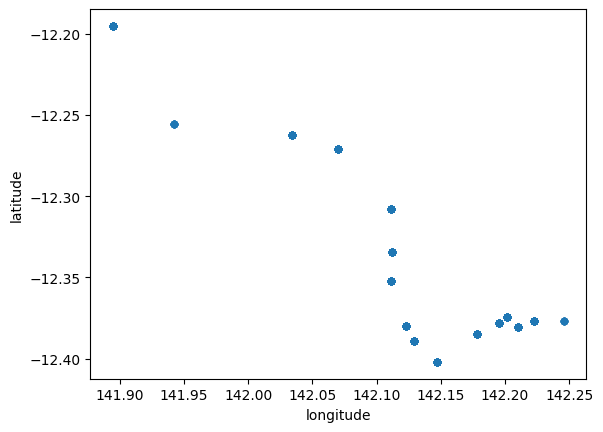

In [11]:
df[df['installation_name']== "Wenlock River"].plot.scatter(x='longitude', y='latitude')

## Create a TIME and scalar/number filter

In [12]:
filter_time = create_time_filter(parquet_ds, date_start='2006-07-12', date_end='2023-02-05', time_varname='detection_timestamp')

expr_1 = pc.field('transmitter_id') == pa.scalar('A69-1105-106')
filter = expr_1 & filter_time

In [13]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36718 entries, 0 to 36717
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   detection_timestamp       36718 non-null  datetime64[ns]
 1   installation_name         36718 non-null  object        
 2   station_name              36718 non-null  object        
 3   receiver_name             36718 non-null  object        
 4   latitude                  36718 non-null  float64       
 5   longitude                 36718 non-null  float64       
 6   sensor_value              36718 non-null  float64       
 7   sensor_unit               36718 non-null  object        
 8   FDA_QC                    36718 non-null  float32       
 9   Velocity_QC               36718 non-null  float32       
 10  Distance_QC               36718 non-null  float32       
 11  DetectionDistribution_QC  36718 non-null  float32       
 12  DistanceRelease_QC

<Axes: xlabel='longitude', ylabel='latitude'>

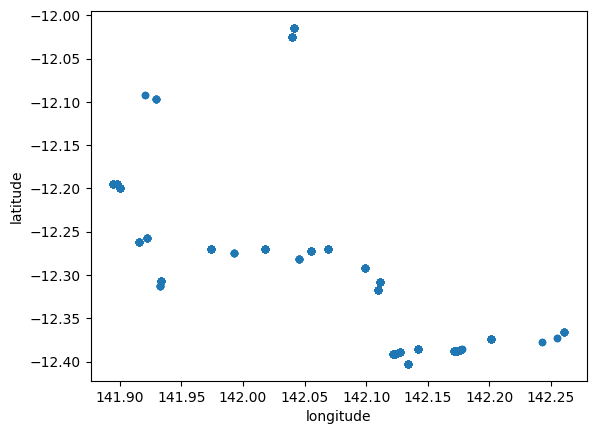

In [14]:
df[df['installation_name']== "Wenlock River"].plot.scatter(x='longitude', y='latitude')